# Group Delay Extraction
A 2DSI-map contains the information of the laser pulses' spectral phase. This information is directly retrievable, which is a big advantage compared to other methods.
Once a 2DSI-map is experimentally measured, the phase retrieval algorithm is applied. In this notebook the 2DSI-map's data, which was created computationally in the 2DSI Map Creator notebook, will be taken for retrieval.

The extraction of the Group Delay (GD) is the first step of the phase retrieval algorithm.

$$S_{2DSI}(\omega, \tau_{CW}) = S(\omega) + S(\omega-\Omega) + \sqrt{S(\omega) S(\omega-\Omega)} cos(\Phi_0 + \color{green}{\Phi(\omega)- \Phi(\omega - \Omega)})$$

$S_{2DSI}(\omega, \tau_{CW})$ is describing the behaviour of it and the relevant information lies within the argument of the cosine.

### Why Group Delay Extraction?
This can be seen when looking at the definition of the GD, which is:

$$GD(\omega ') = \frac{d\Phi(\omega ')}{d\omega'} |_{\omega' = \omega - \frac{\Omega}{2}} \approx - \frac{\color{green}{\Phi(\omega)- \Phi(\omega - \Omega)}}{\Omega}.$$

Hence, the information in the 2DSI-map enables the direct measurement of the GD (for sufficiently small shear frequencies), which futher on enables the reconstruction of the spectral phase.

The remainder of this notebook will be about the extraction of this phase argument (green) in the cosine.
(More on how the phase will be exactly taken from the measured 2DSI map will be covered in the Group Delay Integration notebook.)

## Import of the data and packages:

In [1]:
#Import of packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import sys
from scipy.interpolate import interp1d

#Import of the data
df_pulse = pd.read_csv("Data/Pulse.csv", index_col = 0)
df_2DSImap = pd.read_csv("Data/2DSImap.csv", index_col = 0)

In [2]:
#Create numpy arrays out of the imported data
#Pulse
f = df_pulse.loc[:, 'f (Hz)'].to_numpy()           #frequency axis pulse
i_f = df_pulse.loc[:, 'spec (norm.)'].to_numpy()   #spectrum (intensity) pulse
phase = df_pulse.loc[:, 'phase (rad)'].to_numpy()  #phase of the pulse
f_center = np.round(np.average(f, weights = i_f) / 10**12, 1) #weighted sum for the computation of the center_frequency

f_shear = df_pulse.loc[:, 'shear (Hz)'].to_numpy() #shear of the 2DSI-map
f_shear = f_shear[0]                               #only one value is needed

#2DSI map
f_center_SFG = f_center * 2                        #f_center * 2 per defintion of the Map Creator
map_2DSI = df_2DSImap.loc[:, :].to_numpy()         #2DSI map values

phi_0_array = df_2DSImap.index.to_numpy()          #y-axis
phi_0_array = phi_0_array.astype(float)            #cast elements to float

f_2DSI = df_2DSImap.columns.to_numpy()             #x-axis
f_2DSI = f_2DSI.astype(float)                      #cast elements to float

### How to extract the GD?
#### Side-band Finding:
The 2DSI signal's cosine phase argument can be extracted by taking slices of the 2DSI-map at each frequency and Fourier transforming it through the FFT algorithm. In other words, the Fourier transform is applied for each frequency along the signal-modulated axis (the 2DSI-map's y-axis). As $\Phi_0$ varies and modulates the cosine, it creates a side-band in the Fourier transformed frequency domain (Note that the Fourier transform is symmetric because all data is real-valued). Here we are not interested on the side-band position's unit but only on its position. The position of the side-band is dependent on the amount of periods covered by the varrying $\Phi_0$ (e.g. 2DSI-map with 5 fringes => side-band at FT-frequency axis position 5).
Once the Fourier transform is applied, the side_band_finder function returns the position of the side-band.

In [3]:
len_phi_0_array = len(phi_0_array)                          #Length of the phi_0 array
len_f_2DSI = len(f_2DSI)                                    #Length of the 2DSI map's frequency axis

#Eeach Fourier transformed slice will be saved in this matrix, which needs to save complex numbers.
fft_slice_matrix = np.zeros((len_f_2DSI, len_phi_0_array), dtype = np.complex_)

for i, _ in enumerate(f_2DSI):                               
    slice_map_2DSI = map_2DSI[:, i]                         #A slice of the 2DSI map get taken at the frequency: f_2DSI[i]
    fft_slice = np.fft.fft(slice_map_2DSI)                  #The slice is Fourier transformed along the phi_0 array axis
    fft_slice_matrix[i, :] = fft_slice                      #The slice is saved in the matrix

def side_band_finder(fft_matrix):
    #This function automatically finds the side band value of the FFT and returns the index of the sideband.
    #fft_matrix...Fourier transformed 2DSI-map
    normed_fft_slice_matrix = np.transpose(np.abs(fft_matrix)**2) #Making the data real-valued
    sum_of_all = np.sum(normed_fft_slice_matrix, 1)               #Summing up all FFT-slices
    len_fft_axis = len(sum_of_all)                                #Length of the FFT-pseudo-frequeny axis
    
    #The search for the largest value in the FFT starts at 1 to neglect the DC terms. Then +1 gets added to compensate.
    return int(np.argwhere(sum_of_all[1: int(len_fft_axis / 2)] == np.max(sum_of_all[1: int(len_fft_axis / 2)]))) + 1
    
side_band_value = side_band_finder(fft_slice_matrix)

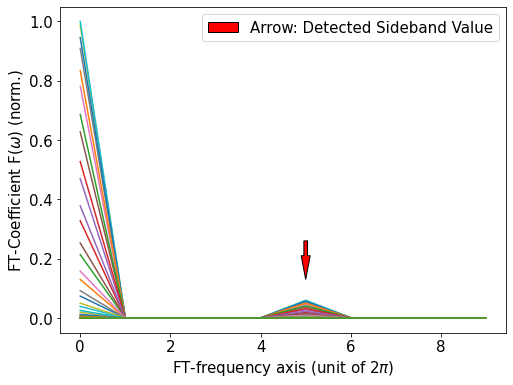

In [4]:
#Plot of the Fourier transform sidebands
figMapFFT = plt.figure(figsize = (8, 6))
ax = figMapFFT.add_subplot(111)

#Fourier coefficient magnitude over the pseudo-fruequency domain. For demonstration purposes, they get normed.
normed_fft = np.transpose(np.abs(fft_slice_matrix[::10, 0:10])**2) / np.max(np.transpose(np.abs(fft_slice_matrix[::10, 0:10])**2))
ax.plot(normed_fft) #Every 10th slice gets shown from the index 0 to 10.

#Indication of the found sideband index through an arrow:
ax.arrow(side_band_value, 0.3, 0, -0.05, width = 0.08, head_length = 0.08 , head_width = 0.2, fc = 'red', head_starts_at_zero = True, label = 'Arrow: Detected Sideband Value')


ax.legend(fontsize = 15)
#Title and labels
ax.set_ylabel('FT-Coefficient F($\omega$) (norm.)', fontsize = 15)
ax.set_xlabel('FT-frequency axis (unit of 2$\pi$)', fontsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

#Figure Caption
figurecounter = 1                                                             #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'Fourier transformed 2DSI-map slices')
figMapFFT.text(.5, -0.05, figurecaption, ha = 'center', fontsize = 15)         #Figure caption

plt.show()


At the position of the side-band, we evaluate the angle of the Fourier coefficients and per definition it is the wanted phase argument:
$$\color{green}{\Phi(\omega) - \Phi(\omega - \Omega)} =  tan ^{-1} \left( \frac{Im \left( F(\omega_{Sideband}) \right)}{Re \left( F(\omega_{Sideband}) \right)} \right)$$

In [5]:
#Extraction of the cosines' argument:
GDOmega = [np.arctan2(np.imag(slice_i[side_band_value]), np.real(slice_i[side_band_value])) for slice_i in fft_slice_matrix] #unit: rad

Consequently, due to the fact that inverse trigonometric functions only map into the range of $[-\pi, \pi]$, numpy's unwrapping function is applied.

In [6]:
#Unwrapping of the cosines' argument:
GDOmega = np.unwrap(GDOmega)

An zeroth order value (constant term) results in a linear spectral phase term. This should be avoided, as a linear spectral phase is in general not often of interest, as it does not affect the pulses' shape. Furthermore, due to the FFT-method there is an ambuiguity of finding the value that compensates it.
However, it can be found out by finding the frequency that results in the largest signal of the cosine modulated 2DSI-map. Therefore the zeroth order value is canceled by shifting GDOmega such that it is 0 at this frequency.

In [7]:
#Adding and removing absolute values is always possible since it results in the unneeded linear spectral phase term only
max_signal_frequency_index = np.argwhere(map_2DSI == np.max(map_2DSI))[0][1]

GDOmega = GDOmega - GDOmega[max_signal_frequency_index] #Shift the zeroth order GD value to 0

In [8]:
#For getting the GD in seconds, the angular shear frequency (unit: rad) has to be divided by GDOmega.
#The minus sign is per definition from the second equation above.

GD = - GDOmega / (2 * np.pi * f_shear) * 10**15 #in femtoseconds (1 fs = 10**-15 s)

### Plot of the extracted GD ontop of the 2DSI-map:

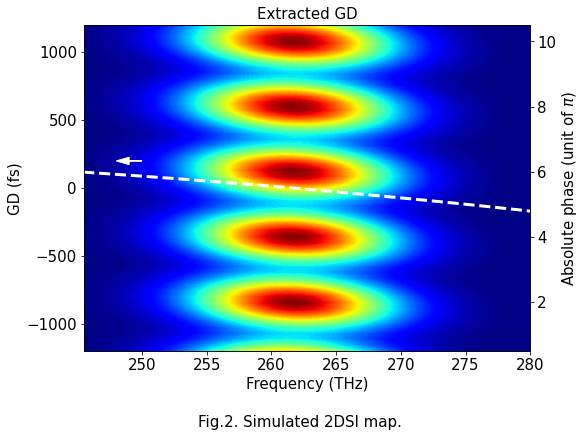

In [9]:
(f_2DSI_2D, phi_0_array_2D) = np.meshgrid(f_2DSI, phi_0_array)                  #Creation of the 2D array fields for the countour plot

figMap2DSI = plt.figure(figsize = (8, 6))
ax0 = figMap2DSI.add_subplot(111)
ax0.set_zorder(1)
ax1 = ax0.twinx()

ax0.patch.set_visible(False)

#GD
ax0.plot(f_2DSI / 10**12, GD, '--', color = 'white', linewidth = 3)
ax0.arrow(250, 200, -1, 0, head_length = 1, head_width = 55, color = 'white')

#2DSI map
ax1.contourf(f_2DSI_2D / 10**12, phi_0_array_2D / np.pi, map_2DSI, 100, cmap = 'jet') #contour plot of the 2DSI map



#Title and labels
ax0.set_title("Extracted GD", fontsize = 15)
ax1.set_ylabel(r"Absolute phase (unit of $\pi$)", fontsize = 15)
ax0.set_ylabel("GD (fs)", fontsize = 15)
ax0.set_xlabel("Frequency (THz)", fontsize = 15)

ax1.tick_params(axis = 'both', which='major', labelsize = 15)
ax0.tick_params(axis = 'both', which='major', labelsize = 15)

ax1.tick_params(which = 'major', axis = 'x', direction = 'out')                   #x-axis ticks outside of contour plot region
ax1.tick_params(which = 'major', axis = 'y', direction = 'out')                   #y-axis ticks outside of contour plot region

#Figure Caption
figurecounter += figurecounter                                                    #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'Simulated 2DSI map.')

figMap2DSI.text(.5, -0.05, figurecaption, ha = 'center', fontsize = 15)         #Figure caption

#Limits
ax0.set_xlim((245.5, 280))
ax0.set_ylim((-1200, 1200))
plt.show()

## Creating a pandas data frame:

In [10]:
#Dataframe for the pulse:
data_GDOmega = {'f (Hz)': f_2DSI, 'GDOmega (rad)': GDOmega, 'shear (Hz)': f_shear, 'f_c_SFG (Hz)': f_center_SFG * 10**12}        #creation of a dictonary
df_GDOmega = pd.DataFrame(data = data_GDOmega)

#Save to csv-file in the Data folder
df_GDOmega.to_csv('Data/GDOmega.csv')